In [1]:
from shapely.geometry import Point, Polygon
import geopandas as gpd
import osmnx as ox
import matplotlib as mpl
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from os.path import exists, join
from descartes import PolygonPatch
import folium
from tqdm import tqdm, tqdm_pandas
from geopy.distance import vincenty
from numpy import dot, arccos, sign, cross, degrees
from numpy.linalg import norm
from tqdm import tqdm, tqdm_pandas
tqdm_pandas(tqdm, leave=True)

%matplotlib inline  


# To Do 
- calculate city block nodes using osmxn simplified graph, then get city block edges from non-simplified graph (original street graph). Using simplified graph will remedy the problem of recursion depth limit, as well as shortening the runtime. Getting the edges from the original graph will give city blocks with a smooth path. 
 - for each vertex in the simplest graph, find the nodes from the original street graph that are part of the vertex
 

In [2]:
PLOT_ALL = False

In [3]:
from config import * 
### SPEED-UP SETTINGS
remove_road_curves = False
remove_dead_ends = True
cityblock_use_cached = False

# Tokyo latitude~=36.2 (in osmnx 'y') and longitude (in osmnx 'x')~= 139
areas_filename = get_cityblock_geojson_filename(area_name=area_name, radius=radius)
print(areas_filename)

/Users/halfdan-rump/projects/datalab/data/areas/shinjuku-1000.geojson


In [4]:
filename = '{}-{}-{}.graphml'.format(area_name, radius, network_type)
filename_simplified = '{}-{}-{}-simplified.graphml'.format(area_name, radius, network_type)
filename_simplest = '{}-{}-{}-simplest.graphml'.format(area_name, radius, network_type)

In [5]:
def remove_endpaths(g, plot_all=False):
    '''
    remove dead end roads from graph g
    '''
    
    simpler = g.to_undirected().copy()
    while True:
        
        nc = ['r' if degree <= 1 else 'b' for node, degree in simpler.degree().items()]
        n_nodes = len(simpler.nodes())        
        n_removed = len(list(filter(lambda x: x=='r', nc)))
#         print('number of nodes in graph: {}, and number of nodes that will be removed: {}'.format(n_nodes, n_removed))
        if plot_all:
            ox.plot_graph(simpler, node_color=nc, node_zorder=3)

        for node, degree in simpler.degree().items():
            if degree <= 1: 
                simpler.remove_node(node)

        if len(simpler.nodes()) == n_nodes:
            break
    return simpler




In [6]:
def get_bounding_box_path_coords(path_coords):
    x = [p[0] for path in path_coords for p in path]
    y = [p[1] for path in path_coords for p in path]
    return (np.min(x), np.max(x)), (np.min(y), np.max(y))

In [7]:
def summarize_graph(g):
    print('number of nodes: {}'.format(len(g.nodes())))
    print('number of edges: {}'.format(len(g.edges())))

### Load street graph
Use cached data if available, otherwise download first and then save to disk

In [8]:
if exists(join(graph_folder, filename)) and cityblocks_use_cached:
    print('restoring full street graph from disk')
    street_graph = ox.load_graphml(filename=filename, folder=graph_folder)
else:
    print('downloading street graph')
    street_graph = ox.graph_from_point(
        origin_osmnx, 
        distance=radius,
        distance_type='network', 
        network_type=network_type, 
        simplify=False)
    
    print('saving graph to disk')
    ox.save_graphml(
        street_graph, 
        filename=filename, 
        folder=graph_folder)
    
summarize_graph(street_graph)

downloading street graph
saving graph to disk
number of nodes: 1228
number of edges: 2027


In [9]:
if remove_road_curves:
    if exists(join(graph_folder, filename_simplified)) and cityblock_use_cached:
        print('restoring graph with no curving roads from disk')
        street_graph = ox.load_graphml(filename=filename_simplified, folder=graph_folder)
    else:
        print('simplifying graph by removing curved roads')
        street_graph = ox.simplify_graph(street_graph)

        print('saving simplified graph to disk')
        ox.save_graphml(street_graph, 
                        filename=filename_simplified, 
                        folder=graph_folder)
summarize_graph(street_graph)

number of nodes: 1228
number of edges: 2027


In [10]:
street_graph = remove_endpaths(street_graph)

Plotting street graph after removing end paths. Notice that all the dead-end roads have been removed.

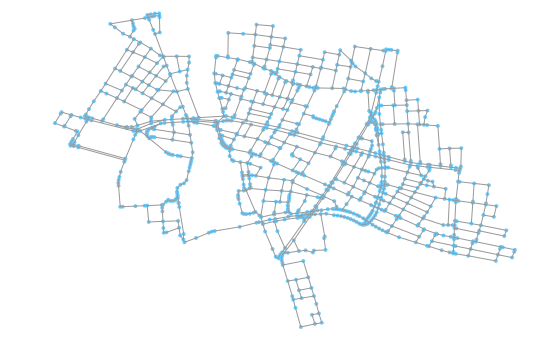

(<matplotlib.figure.Figure at 0x10bfef668>,
 <matplotlib.axes._subplots.AxesSubplot at 0x10bfdccf8>)

In [11]:
ox.plot_graph(street_graph)

Plotting the projected graph

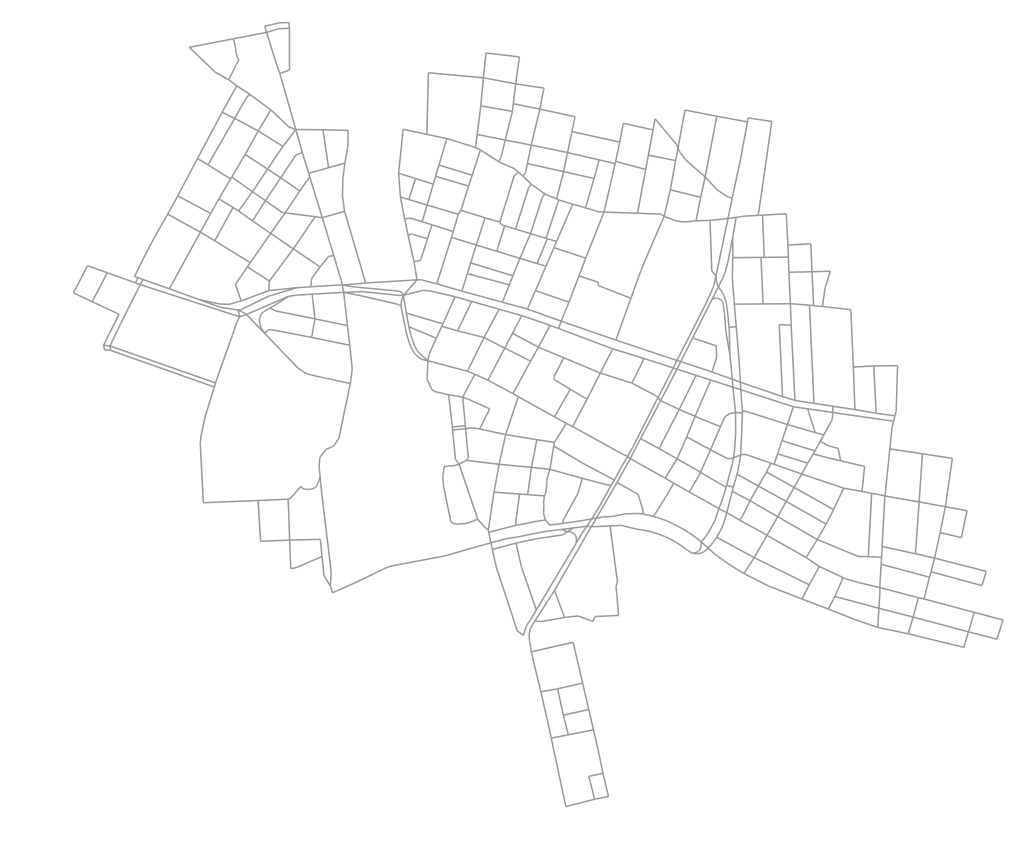

In [12]:
ox.plot_graph(ox.project_graph(street_graph), fig_height=15, node_size=0, edge_linewidth=1.5);

In [13]:
street_graph = street_graph.to_undirected()

## Calculate city blocks

In [14]:
from city_blocks import city_blocks

In [21]:
areas = city_blocks(street_graph)

100%|██████████| 2680/2680 [00:09<00:00, 270.60it/s]


In [22]:
PLOT_POLYGONS = False

In [23]:
print('number of areas: {}'.format(len(areas)))

invalid = areas[areas.is_valid == False]
if not invalid.empty: 
    invalid.plot()


number of areas: 264


In [24]:
print('number of areas after removing invalid polygons: {}'.format(len(areas)))
# areas=areas[areas.geometry.is_empty]
# print('number of areas after removing empty polygons: {}'.format(len(areas)))
#areas.loc[invalid.index, 'geometry'] = invalid.geometry.apply(lambda x: x.buffer(0))

areas=areas[areas.geometry.is_valid]
areas.reset_index(inplace=True, drop=True)



number of areas after removing invalid polygons: 264


Find MultiPolygons and extract simple polygons. Then create new dataframe with all polygons.

In [25]:
multi_pol_idx = np.where(areas.geom_type == 'MultiPolygon')[0]
extra_pols = gpd.GeoDataFrame(
    {'geometry': [p for mp in areas.loc[multi_pol_idx].geometry for p in mp.geoms]})

# areas = areas.copy()
# areas.drop(multi_pol_idx, inplace = True)
# areas = areas.append(extra_pols)
# areas.reset_index(inplace=True, drop=True)

## Save areas as GeoJson

In [26]:
with open(areas_filename, 'w') as af: 
    af.write(areas.to_json())

In [ ]:
# import folium
# m = folium.Map(location=origin_osmnx, tiles='Stamen Toner',
#                     zoom_start=15)

# folium.GeoJson(
#     areas.to_json()
# ).add_to(m)

# m
# m.save('pyconjp2017/html/daikanyama_1000_notsimplified.html')

In [ ]:
areas.plot(figsize=(15,15))

In [ ]:
ox.plot_graph_folium(street_graph)